In [1]:

#Image visualization and interaction
import cv2 as cv
from skimage import data
import skimage
import napari
from PyQt5.QtWidgets import QMainWindow, QLabel, QPushButton
from PyQt5.QtWebEngineWidgets import QWebEngineView
import imageio

# scRNA-seq
import scanpy as sc
import scConnect as cn
import bone_fight as bf


#PLotting
import matplotlib.pyplot as plt
import plotly
import plotly.express as px


#Core packages for data manipulation
import pandas as pd
import scipy as sp
import numpy as np




# Image segmentation
from cellpose import models
#import stardist





2022-01-26 14:24:57,845 [INFO] WRITING LOG OUTPUT TO C:\Users\jonja158\.cellpose\run.log


In [2]:
# Create a data class to hold information about the experiment and provide methods for simple manipulation
# such as filtering out cells without gene expression
# * gene xy table
# * Cell segmentation
# * cell/reads matrix

class spatialExperiment():
    """class holding information related to a spatial experiment.
    
    methods
    -------
    load_genes: path to table holding gene xy coordinates
    load_cell_segmentation_image: Path to image holding cell segmentation
    load_cell_segmentation_metadata: Path to table holding metadata about the segmentation (as delivered by ilastik)
    
        
    """
    def __init__(self):
        self.genes = pd.DataFrame()
        self.images = list()
        pass
        
    
    def load_genes(self, path: str, gene: str="Gene", x: str="PosX", y: str="PosY", **kvargs) -> pd.DataFrame:
        """load genes to a standardised DataFrame
        attributes:
        ----------
        path: path to csv table
        gene: name of gene name column
        x: name of x position column
        y: name of y position column
        
        **kvargs are passed to the pd.read_csv for loading
        
        return:
        -------
        pd.DataFrame with gene name and x, y coordinates
        """
        
        # load the table
        _df = pd.read_csv(path, **kvargs)
        # subset the table to gene, x and y
        _df = _df[[gene, x, y]]
        # standardize the naming of columns
        _df.columns = ["gene", "x", "y"]
        # set propper datatype
        _df = _df.astype({"gene":str, "x": int, "y": int})
        self.genes = _df
        
    def load_cell_segmentation_image(self, path: str) -> np.ndarray:
        """load image containing cell segmentation. Each object has unique pixle value.
        
        files are opened using openCV.
        
        attributes:
        -----------
        path: path to image
        
        return:
        -------
        np.ndarray
        
        """
        import cv2 as cv
        
        _img = cv.imread(path, flags=cv.IMREAD_ANYDEPTH)
        self.cellSegmentationImage = _img.astype(int)
        self._find_properties()
    
    def _find_properties(self):
        """Detect and store information about segmented objects"""
        import skimage as ski
        self.cellSegmentationMetadata = pd.DataFrame(
            ski.measure.regionprops_table(
                self.cellSegmentationImage, properties=["label", "centroid", "area", "orientation"])
        )
            
        
        
        
    def assign_gene_to_cell(self):
        # Go through all genes and map them to the object they are positioned on (map to object ID)
        # We use the column ParentCell to annotate object ID for each gene
        cell_ids = list()
        for (i, gene) in self.genes.iterrows():
            cell_id = self.cellSegmentationImage[gene["y"], gene["x"]] #Note the x and y orientation
            cell_ids.append(cell_id)

        # Add the object ID vector to the gene table
        self.genes["cell"] = cell_ids
    
    

In [3]:
spatial = spatialExperiment()
spatial.load_genes("../data/wt/raw/QT_0.3_details_noNNNN.csv")
spatial.load_cell_segmentation_image("../data/wt/processed/CLAHE_dapi_c5_Object Identities.tif")
spatial.cellSegmentationMetadata

,label,centroid-0,centroid-1,area,orientation
0,1,1745.518144,6396.934265,3362,1.089362
1,2,1771.005519,6258.287005,3986,-1.029081
2,3,1802.456331,6408.061904,5347,-1.150616
3,4,1823.538055,6918.559725,3784,0.640310
4,5,1841.826912,5488.336963,3582,-0.031635
...,...,...,...,...,...
4002,4003,14883.656943,10379.765319,6136,0.204457
4003,4004,14859.950591,9280.882260,7610,-0.380787
4004,4005,14824.285286,9937.648821,2671,1.482203
4005,4006,14942.222441,10284.187828,6096,0.192160


In [4]:
image_path = "../data/wt/processed/CLAHE_dapi_c5.tif"
img2 = imageio.volread(image_path)
model = models.Cellpose(model_type='cyto', omni=False, gpu=True)

2022-01-26 14:25:02,046 [INFO] TORCH CUDA version not installed/working.
2022-01-26 14:25:02,047 [INFO] >>>> using CPU


In [20]:
crop = img2[:,3000:4000, 3000:7000]

In [21]:
channels = [[2,1]]

masks, flows, styles, diams = model.eval(
    crop, 
    diameter=120, augment=True,
    channels=channels, batch_size=8,
    verbose=True,
    flow_threshold=0.6, #Increase this threshold if cellpose is not returning as many masks as you’d expect. Similarly, 
                        #decrease this threshold if cellpose is returning too many ill-shaped masks.
    mask_threshold=-1.0,#Decrease this threshold if cellpose is not returning as many masks as you’d expect. Similarly, 
                        #increase this threshold if cellpose is returning too masks particularly from dim areas.
)

2022-01-26 14:32:55,792 [INFO] ~~~ FINDING MASKS ~~~
2022-01-26 14:32:55,793 [INFO] Evaluating with omni 0, cluster 0, flow_threshold 0.600000
2022-01-26 14:33:22,039 [INFO] mask_threshold is -1.000000
2022-01-26 14:33:23,874 [INFO] resizing output with resize = [1000, 4000]
2022-01-26 14:33:23,990 [INFO] >>>> TOTAL TIME 28.20 sec


In [22]:
# Resize flow image to the same dimenition as original image
flow = skimage.transform.resize(flows[0], crop.shape[1:3])

In [23]:
#viewer.close()
viewer = napari.Viewer()

viewer.add_image(crop, channel_axis=0, name=["Dapi", "Cytoplasm"], blending=["translucent", "additive"])
viewer.add_image(flow, name="cellpose")
viewer.add_labels(masks, name="cellID")


<Labels layer 'cellID' at 0x1d1c954cb70>

In [ ]:
from stardist.models import StarDist2D
# prints a list of available models 
StarDist2D.from_pretrained() 

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')


In [ ]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

labels, _ = model.predict_instances(normalize(m_arr), n_tiles=(3,3), prob_thresh=0.3, nms_thresh=0.1)


In [ ]:
viewer = napari.Viewer()
viewer.add_image(m_arr)
viewer.add_labels(labels)
viewer.show()

In [12]:
#Load the ISS gene expression data
gene_path = "../data/wt/raw/QT_0.3_details_noNNNN.csv"
genes = pd.read_csv(gene_path)
genes

,Read,Gene,PosX,PosY,ParentCell,Tile,MinAnchor,MinQuality,MinAlign
0,CGGG,Gfap,3293.559,1136.034,0,2,0.000001,0.335714,0.000001
1,CGTG,Adamts5,5526.000,1786.000,0,3,0.000001,0.439024,0.000001
2,CGGG,Gfap,5768.613,1789.000,0,3,0.000001,0.301587,0.000001
3,CGGG,Gfap,5541.500,1793.500,0,3,0.000001,0.317073,0.000001
4,CGGG,Gfap,5760.850,1794.225,0,3,0.000001,0.303030,0.000001
...,...,...,...,...,...,...,...,...,...
11600,CGGG,Gfap,12096.600,14072.530,0,63,0.000001,0.490566,0.000001
11601,CGGG,Gfap,12108.070,14073.020,0,63,0.000001,0.325581,0.000001
11602,CGTG,Adamts5,12006.330,14082.220,0,63,0.000001,0.318182,0.000001
11603,CGGG,Gfap,12114.500,14087.500,0,63,0.000001,0.333333,0.000001


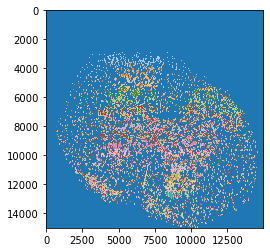

In [13]:
# Load the object classification image from ilastik (after training and segmenting cells)
# Each object has its object ID as the pixel value in the image
image_path = "../data/wt/processed/CLAHE_dapi_c5_Object Identities.tif"
img = cv.imread(image_path, flags=cv.IMREAD_ANYDEPTH)
img = img.astype(int)
plt.imshow((img), cmap="tab20")

In [14]:
# Go through all genes and map them to the object they are positioned on (map to object ID)
# We use the column ParentCell to annotate object ID for each gene
objectids = list()
for (i, gene) in genes.iterrows():
    x = int(gene["PosX"])
    y = int(gene["PosY"])
    objectid = int(img[y,x]) #Note the x and y orientation
    objectids.append(objectid)

# Add the object ID vector to the gene table
genes["ParentCell"] = objectids
# Filter our genes not on a cell
#genes = genes[genes["ParentCell"]>0]

In [15]:
genes.head(20)

,Read,Gene,PosX,PosY,ParentCell,Tile,MinAnchor,MinQuality,MinAlign
0,CGGG,Gfap,3293.559,1136.034,0,2,0.000001,0.335714,0.000001
1,CGTG,Adamts5,5526.000,1786.000,0,3,0.000001,0.439024,0.000001
2,CGGG,Gfap,5768.613,1789.000,0,3,0.000001,0.301587,0.000001
3,CGGG,Gfap,5541.500,1793.500,0,3,0.000001,0.317073,0.000001
4,CGGG,Gfap,5760.850,1794.225,0,3,0.000001,0.303030,0.000001
5,CGTG,Adamts5,5766.375,1803.156,0,3,0.000001,0.318182,0.000001
6,CGGG,Gfap,5484.151,1824.562,5,3,0.000001,0.371728,0.000001
7,CGTG,Adamts5,5489.500,1832.744,5,3,0.000001,0.372093,0.000001
8,CGGG,Gfap,5442.087,1842.413,0,3,0.000001,0.338462,0.000001
9,CGGG,Gfap,5673.226,1843.226,0,3,0.000001,0.355932,0.000001


In [16]:
# Save the filtered list. Can be used in TissUUmap. Not really useful though.
genes.to_csv("../data/wt/raw/filtered_reads.csv")

In [17]:
# Extract a cell-gene expression matrix by pivotin the genes table on ParentCell
target = genes.pivot_table(index="Gene", columns="ParentCell", values="Tile", aggfunc=len, fill_value=0)

#Drop the ID 0 as this is backgound i.e. not mapping to a cell
target = target.drop(columns=0)

target

ParentCell,1,2,5,7,8,9,10,11,12,14,...,3994,3996,3998,4001,4002,4003,4004,4005,4006,4007
Gene,,,,,,,,,,,,,,,,,,,,,
Adamts5,1,0,2,0,0,1,0,0,0,0,...,2,0,0,0,1,0,0,0,1,1
Aif1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Calb2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cck,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cplx1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cpne4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Crabp1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,1,1,0,0,0
Csf1r,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ecel1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Import review reference atlas
adata = sc.read_loom("../reference datasets/harmonized.loom")
#adata_h = sc.read_h5ad("../reference datasets/harmonized.h5ad")
print(adata)

# Simplified cell type mapping
cellTypeMapping = {
    1:'OPC',
    2:'Oligo',
    3:'Oligo',
    4:'Oligo',
    5:'Oligo',
    6:'Schwann',
    7:'Peripheral Glia/BC Derivative',
    8:'Meninges',
    9:'Meninges',
    10:'Ependymal',
    11:'Astrocytes',
    12:'Astrocytes',
    13:'Endothelial',
    14:'Pericytes',
    15:'Microglia',
    16:'Motorneuron',
    17:'Neuron',
    18:'Doublets',
    19:'Junk'
}
# Real cell type mapping
cellTypeMappingTrue = {
    1:'OPC',
    2:'Oligo Progen 1',
    3:'Oligo Progen 2',
    4:'Oligos 1',
    5:'Oligos 2',
    6:'Schwann',
    7:'Peripheral Glia/BC Derivative',
    8:'Meninges 1',
    9:'Meninges 2',
    10:'Ependymal',
    11:'Astrocytes 1',
    12:'Astrocytes 2',
    13:'Endothelial',
    14:'Pericytes',
    15:'Microglia',
    16:'Motorneuron',
    17:'Neuron',
    18:'Doublets',
    19:'Junk'
}

adata.obs["harmonized_clusters"] = [ cellTypeMapping[cluster] for cluster in adata.obs.final_coarse_clusters]
adata.obs["harmonized_clusters"].value_counts()

KeyboardInterrupt: 

In [ ]:
# Remove junk
adata = adata[[cluster not in ["Junk", "Doublets", "Schwann"] for cluster in adata.obs.harmonized_clusters]].copy()
adata

# Import Häring reference atlas
adata_h = sc.read_csv("../Häring/counts.csv", delimiter=";").T
meta = pd.read_csv("../Häring/metadata.csv", sep=";", index_col=0)
adata_h.obs = meta
adata_h

In [ ]:
adata.X = adata.X.todense()

In [ ]:
# Calculate a mean gene expression matrix. Here scConnect comes in useful
#reference = cn.genecall.meanExpression(adata, groupby="standard_names", return_df=True, transformation=False)
reference = cn.genecall.meanExpression(adata, groupby="harmonized_clusters", return_df=True, transformation=False, use_raw=False)
reference

In [ ]:
# Find genes used in both target and reference
target_genes = set(genes.Gene)
reference_genes = set(reference.index)
intersect_genes = target_genes.intersection(reference_genes)


In [ ]:
# Find the number of cells detected for each cell type in the reference dataset
#reference_volume = adata.obs.standard_names.value_counts(sort=False)[reference.columns]
reference_volume = adata.obs.harmonized_clusters.value_counts(sort=False)[reference.columns]
print(reference_volume)
reference_volume["Neuron"] = 100000
# turn into a numpy array as this is needed by bonefight
reference_volume = reference_volume.to_numpy()
print(reference_volume)

In [ ]:
# Filter out onlt the intersect genes in the reference dataset
reference_f = reference.filter(intersect_genes, axis=0)


# Turn into a numpy array for Bonefight
reference_tensor = reference_f.to_numpy().T

In [ ]:
# Create a view of the reference dataset
a = bf.View(reference_tensor, reference_volume)

In [ ]:
# Filter out only incomon genes of the target (ISS) dataset and tun into a numpy array
target_tensor = target.filter(intersect_genes, axis=0).to_numpy().T
target_tensor.shape

In [ ]:
# Create a view for the ISS data with the volumes of 1
# We do not assume volume of these objects as they are all just one cell each.
b = bf.View(target_tensor, np.ones(target_tensor.shape[0]))

In [ ]:
model = bf.BoneFight(a, b).fit(200, 0.1)

In [ ]:
# Create a matrix with diagonal 1 and the rest is zero 
# with the size of the number of cell types in the reference dataset
labels = np.eye(reference_tensor.shape[0])
plt.imshow(labels)

In [ ]:
# transform this using the model to predict the cell types of all cell objects
y = model.transform(labels)

In [ ]:
# Add index and column information
prediction = pd.DataFrame(y, columns=reference_f.columns, index = target.columns)
prediction

In [ ]:
# Example of how the prediction data looks like. 
# Some have very unsertain cell type calles and others are very clear
px.bar(prediction[60:100])

In [ ]:
# Load object information
obj_df = pd.read_csv("../data/wt/processed/CLAHE_dapi_c5_table.csv", index_col="labelimage_oid")

# Filter out objects that are not used (objects without any genes)
obj_df = obj_df.filter(prediction.index, axis=0)

In [ ]:
obj_df

In [ ]:
# Create a properties dictionary for each object
# Contain a list of cell types and list of scores
properties = dict(types=list(),
                  scores=list(),
                  objectid=list()
                 )

for cell in obj_df.index:
    # Find the top ranked cell type based on highest score
    if cell in prediction.index:
        cell_type = prediction.loc[cell]
        cell_type = cell_type.idxmax()
    
        # add the score for that cell type
        cell_type_score = prediction.loc[cell][cell_type]
    else:
        cell_type = "unknown"
        cell_type_score = 0
    
    # Add cell type and score to the lists in the dictionary
    properties["types"].append(cell_type)
    properties["scores"].append(cell_type_score)
    properties["objectid"]. append(cell)

In [ ]:
# find x and y coordinates of all filtered objects
y = obj_df["Center of the object_1"] 
x = obj_df["Center of the object_0"]

In [ ]:
# Load a merge image with Dapi and C5 information
import imageio
image_path = "../data/wt/processed/CLAHE_dapi_c5.tif"
img2 = imageio.volread(image_path)

In [ ]:
viewer = napari.Viewer()

@viewer.bind_key('p')
def print_celltypes(viewer):
    layer = viewer.layers["cell types"]
    selected = list(layer.selected_data)
    df = prediction.loc[selected]
    fig = px.pie(names=df.columns, values=df.values[0])
    #print(selected)
    fig.show()
    
# Add the Dapi and C5 image
image_layer = viewer.add_image(img2, channel_axis=0, name=["Dapi", "Cytoplasm"], blending=["translucent", "additive"])

# Add the object ID image as labels
object_id_layer = viewer.add_labels(img, name="object ID", visible=False)

# Add all cell types as text
cell_type_layer = viewer.add_points(list(zip(y,x)), properties=properties, property_choices={"types": list(set(properties["types"]))}, text="types", name="cell types", visible=False)

#Add all genes
gene_layer = viewer.add_points(genes[["PosY", "PosX"]], properties={"gene": genes["Gene"]}, text="gene", visible=False, name="genes")




In [ ]:
from PyQt5.QtWidgets import QMainWindow, QLabel, QPushButton, QVBoxLayout, QHBoxLayout, QWidget
from PyQt5.QtGui import QFont
import PyQt5.QtCore as qtc
from PyQt5.QtWebEngineWidgets import QWebEngineView
from napari.qt.threading import thread_worker
import plotly
import plotly.express as px


h1 = QFont("Arial", 13)

class cellTypeSelectionWidget(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()
        self.last_selection = set()
        
        
        
    def initUI(self):
        
        self.setToolTip("Select on or more cells on the cell types layer to see further information about them")
        
        self.label = QLabel(self)
        self.label.setText("Cell ID:")
        self.label.setFont(h1)
        self.label.move(10,10)
        
        self.plot = QWebEngineView()
        self.plot.setMaximumSize(300,300)
        self.plot.setHtml("")
        
        vbox = QVBoxLayout()
        vbox.addWidget(self.label)
        vbox.addWidget(self.plot)
        vbox.addStretch()
        hbox = QHBoxLayout()
        hbox.addLayout(vbox)
        hbox.addStretch()
        
        
        self.setLayout(hbox)
        
        #detect new selections of points
        cell_type_layer.events.highlight.connect(self.is_new_selection)
        
    def is_new_selection(self, event):
        selection = cell_type_layer.selected_data
        if selection != self.last_selection and len(list(selection)) > 0:
            self.last_selection = selection
            # Run plotting of the selected points
            self.cell_type_plot(selection)

    
    
    def cell_type_plot(self, selection):
        # If only one cell is selected, plot a donut (pie chart)
        if len(list(selection)) == 1:
            """Plots the selected cells as pie chart"""
            plot_idx = list(selection)
            selected = cell_type_layer.properties["objectid"][list(selection)]
            data_frame=prediction.loc[selected]

            fig = px.pie(names=data_frame.columns, values=data_frame.values[0], hole=0.5)
            fig.update_traces(textposition="inside")
            fig.update_layout(font_size=10, showlegend=False)
            fig.update_layout(margin=dict(b=0,t=0, r=0, l=0))


            html = '<html><body>'
            html += plotly.offline.plot(fig, output_type='div', include_plotlyjs='cdn',)
            html += '</body></html>'
            self.plot.setHtml(html)

            self.label.setText(f"Cell ID: {selected[0]}")
        
        # IF more than one cell is selected plot a bar chart
        elif len(list(selection)) > 1:
            plot_idx = list(selection)
            selected = cell_type_layer.properties["objectid"][list(selection)]
            data_frame=prediction.loc[selected]
            
            fig = px.bar(data_frame=data_frame.T, barmode="relative")
            fig.update_traces(textposition="inside")
            fig.update_layout(font_size=10, showlegend=False)
            fig.update_layout(margin=dict(b=0,t=0, r=0, l=0))
            
            html = '<html><body>'
            html += plotly.offline.plot(fig, output_type='div', include_plotlyjs='cdn',)
            html += '</body></html>'
            self.plot.setHtml(html)

            self.label.setText(f"Many cells celected")

In [ ]:
viewer.window.remove_dock_widget("all")
w = cellTypeSelectionWidget()
viewer.window.add_dock_widget(w, name="Cell Type Selection", area="right", add_vertical_stretch=False)


In [ ]:
from PyQt5.QtWidgets import QListWidget, QListWidgetItem
from vispy.color.colormap import Colormap
from sklearn.preprocessing import minmax_scale

class colorObjectWidget(QWidget):
    def __init__(self):
        super().__init__()
        self.initUI()        
        
        
    def initUI(self):
        
        self.label = QLabel(self)
        self.label.setText("Color objects by gene:")
        self.label.setFont(h1)
        self.label.move(10,10)
        
        self.listwidget = QListWidget(self)
        self.listwidget.move(10,10)
        for gene in target.index:
            self.listwidget.addItem(gene)
        #Connect selection to action
        self.listwidget.itemClicked.connect(self.geneIsSelected)
        
        vbox = QVBoxLayout(self)
        vbox.addWidget(self.label)
        vbox.addWidget(self.listwidget)
        #vbox.addStretch()
        hbox = QHBoxLayout(self)
        hbox.addLayout(vbox)
        hbox.addStretch()
        
        self.layout = hbox
        
    def geneIsSelected(self, listItem):
        gene = listItem.text()
        values = target.loc[gene]
        values = np.log1p(values)
        values = minmax_scale(values)
        cmap = Colormap(["b","r"])
        colors = cmap[values]
        object_id_layer.color = dict(zip(target.columns, colors.rgba))
        
w = colorObjectWidget()
viewer.window.add_dock_widget(w, name="Color Objects", area="right", add_vertical_stretch=True)

In [ ]:
viewer.layers["object ID"].color

In [ ]:
from vispy.color.colormap import Colormap
from sklearn.preprocessing import minmax_scale
values = target.loc["Grp"]
values = minmax_scale(values)
cmap = Colormap(["b","r"])
colors = cmap[values]
dict(zip(target.columns, colors.rgba))

In [ ]:
for gene in target.index:
    print(gene)

def webengine_hack():
    from PyQt5 import QtWidgets
    app = QtWidgets.QApplication.instance()
    if app is not None:
        import sip
        app.quit()
        sip.delete(app)
    import sys
    from PyQt5 import QtCore, QtWebEngineWidgets
    QtCore.QCoreApplication.setAttribute(QtCore.Qt.AA_ShareOpenGLContexts)
    app = QtWidgets.qApp = QtWidgets.QApplication(sys.argv)
    return app
webengine_hack()

In [ ]:
selected = cell_types.properties["objectid"][list(cell_types.selected_data)]
data_frame=prediction.loc[selected]
print(f"cell number {selected} is selected")
fig = px.pie(names=data_frame.columns, values=data_frame.values[0])
image_bytes = fig.to_image("png", scale=2)


import io
from PIL import Image
img = np.array(Image.open(io.BytesIO(image_bytes))) 
viewer.add_image(data=img, name="selected cell", )


In [ ]:
cell_types.selected_data

In [ ]:
selected = cell_types.properties["objectid"][list(cell_types.selected_data)]
selected

In [ ]:
data_frame=prediction.loc[selected]
data_frame

In [ ]:
px.pie(names=data_frame.columns, values=data_frame.values[0])

In [ ]:
data_frame.values[0]

In [ ]:
from dash import dcc
import dash
from dash import html
import plotly.express as px
import pandas as pd

app = dash.Dash(__name__)

df = pd.DataFrame({
    "x": x,
    "y": y,
    "types": properties["types"],
    "scores": properties["scores"],
    "objectID": properties["objectid"]    
})

fig = px.scatter(data_frame=df, x="x", y="y", color="types", hover_data=["scores"])
img = px.imshow(img2[0,:,:])
 
app.layout = html.Div(children=[
    html.H1(children='Hello Dash'),

    html.Div(children='''
        Dash: A web application framework for your data.
    '''),

    dcc.Graph(
        id='example-graph',
        figure=fig
    ),
    dcc.Graph(
        id="image",
        figure=img
    )
])

app.run_server()